In [ ]:
#import pyabf
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
import h5py

In [ ]:
import h5py
import numpy as np
from scipy.signal import butter, filtfilt

def collect_data_points(h5_file, data_list):
    for key in h5_file.keys():
        item = h5_file[key]
        if isinstance(item, h5py.Dataset):
            # Check if the dataset's dtype is numeric (float or int)
            if item.dtype.kind in ['i', 'u', 'f']:  # Integer, unsigned integer, or float
                data_list.append(np.array(item))
            #else:
                #print(f"Skipping dataset {key} due to incompatible dtype: {item.dtype}")
        elif isinstance(item, h5py.Group):
            collect_data_points(item, data_list)

collected_data = []

with h5py.File('Data_Subject_05_Session_01.h5', 'r') as file:
    collect_data_points(file, collected_data)

# Try to concatenate the collected numeric datasets
if collected_data:
    recording1 = np.concatenate(collected_data).flatten()
else:
    #print("No compatible numeric datasets were found to concatenate.")
    recording1 = np.array([])  # Initialize as an empty array if no compatible datasets are found

fsSpikes = 50000
rawsignal = recording1[20 * fsSpikes:260 * fsSpikes] if recording1.size > 0 else np.array([])

# Proceed with bandpass filtering only if rawsignal has data
if rawsignal.size > 0:
    Fc1_spikes, Fc2_spikes = 300, 3000
    b_spikes, a_spikes = butter(4, [Fc1_spikes, Fc2_spikes], btype='band', fs=fsSpikes)
    spikes = filtfilt(b_spikes, a_spikes, rawsignal) * 1000

    Fc1_lfp, Fc2_lfp = 0.5, 300
    b_lfp, a_lfp = butter(2, [Fc1_lfp, Fc2_lfp], btype='band', fs=fsSpikes)
    LFP = filtfilt(b_lfp, a_lfp, rawsignal) * 1000
else:
    #print("No data available for bandpass filtering.")
    spikes, LFP = np.array([]), np.array([])


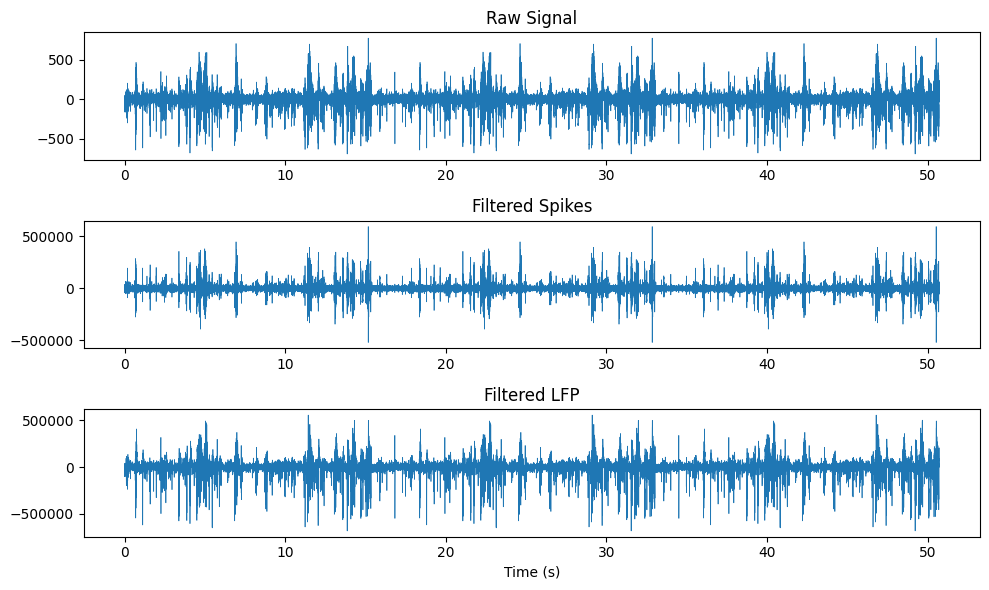

In [ ]:
# Plot
# line 23

time = np.arange(0, len(spikes)) / fsSpikes

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(time, rawsignal, linewidth=0.5)
plt.title('Raw Signal')
plt.subplot(3, 1, 2)
plt.plot(time, spikes, linewidth=0.5)
plt.title('Filtered Spikes')
plt.subplot(3, 1, 3)
plt.plot(time, LFP, linewidth=0.5)
plt.title('Filtered LFP')

plt.xlabel('Time (s)')
plt.tight_layout()

In [ ]:
# Assuming earlier parts of the code are correct and 'collected_data' has been properly populated

# Bandpass filter for Spikes and LFP
if rawsignal.size > 0:
    Fc1_spikes, Fc2_spikes = 300, 3000
    b_spikes, a_spikes = butter(4, [Fc1_spikes, Fc2_spikes], btype='band', fs=fsSpikes)
    spikes = filtfilt(b_spikes, a_spikes, rawsignal) * 1000

    Fc1_lfp, Fc2_lfp = 0.5, 300
    b_lfp, a_lfp = butter(2, [Fc1_lfp, Fc2_lfp], btype='band', fs=fsSpikes)
    LFP = filtfilt(b_lfp, a_lfp, rawsignal) * 1000

# Remove incorrect dictionary access
# lfp_signal = rawsignal['LFP']
# spikes = rawsignal['spike_times']

# Spike detection based on the threshold
upper_threshold = -100
threshold = -20

ind_above = np.where(spikes < threshold)[0]
vector = np.zeros_like(spikes)
vector[ind_above] = spikes[ind_above]

above_threshold = ind_above
delay = int(fsSpikes / 1000 * 1.5)

end_spike_index = []
n = 1

for ii in range(len(above_threshold) - 1):
    if above_threshold[ii] < above_threshold[ii + 1] - delay:
        end_spike_index.append(above_threshold[ii])
        n += 1

spike_index = []
for ii in range(1, len(end_spike_index)):
    window = spikes[end_spike_index[ii] - delay:end_spike_index[ii] + delay]
    M = np.min(window)
    index = np.argmin(window)
    #if M < upper_threshold:
    spike_index.append(end_spike_index[ii] - delay + index)


spike_index = np.array(spike_index)

print(spike_index)

[   2855    9867   10178 ... 2531800 2533340 2535689]


In [ ]:
## Get the 3 ms spike cutout
# line 82

per = 50
detected_spikes = spike_index
num_spikes = len(detected_spikes)
data = np.zeros((num_spikes, 2 * per))

start = np.zeros(num_spikes, dtype=int)
stop = np.zeros(num_spikes, dtype=int)
starttime = np.zeros(num_spikes, dtype=int)

for i in range(num_spikes):
    start[i] = detected_spikes[i] - per
    stop[i] = start[i] + (2 * per)
    data[i][:] = spikes[start[i]:stop[i]]
    starttime[i] = start[i]


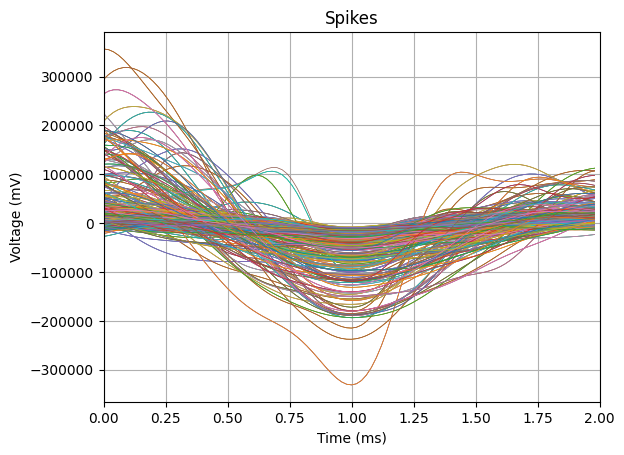

In [ ]:
## PCA analysis
# line 95

data = np.array(data)
#print(data)

# Perform PCA on 'data'
pca = PCA(n_components=2)  # Specify the number of components (3 in this case)
pca = PCA()
coeff = pca.fit_transform(data)
score = pca.components_
ev = pca.explained_variance_

# Calculate the mean of 'data'
mu = np.mean(data, axis=0)

# Select the first 3 principal components
pcadata = coeff[:, :3]

# plot data
time = np.arange(0, 2 * per, 1 / fsSpikes) * 1000

plt.figure()
plt.plot(time[:data.shape[1]], data.T, linewidth = 0.5)
plt.title('Spikes')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim(0, 2 * per * 1000 / fsSpikes)
plt.grid(True)

Text(0, 0.5, 'Voltage (mV)')

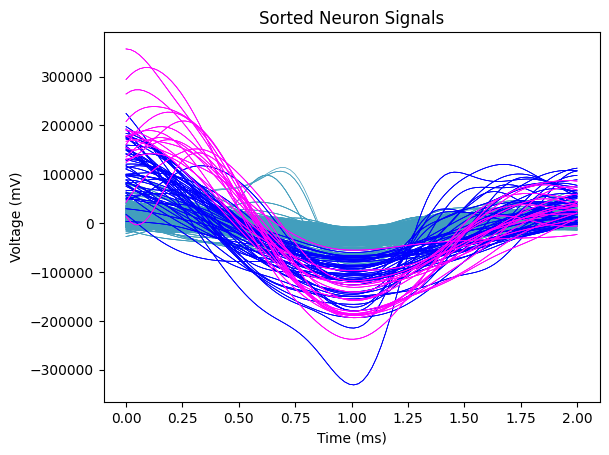

In [ ]:
## line 107

desired_k = 3
kmeans = KMeans(n_clusters=desired_k, init='k-means++', n_init=desired_k + 6, random_state=42)
kmeans.fit(data)
IDX = kmeans.labels_
C = kmeans.cluster_centers_
# Define colors for each cluster
color_cluster = [
    [0.259, 0.62, 0.741],
    [0, 0, 1],
    [1, 0, 1],
    [0.949, 0.498, 0.047],
    [1, 1, 0],
    [0, 1, 1],
    [0.5, 0, 1],
    [0, 0.5, 1],
    [1, 0.5, 0],
    [1, 0, 0.5]
]

## Plot each cluster
plt.figure()
for i in range(desired_k):
    # Select data for the current cluster
    cluster_data = data[IDX == i, :]
#     # Time vector for plotting
    time = np.linspace(0, (2 * per) * 1e3 / fsSpikes, cluster_data.shape[1])
#     # Plot each waveform in the cluster
    for waveform in cluster_data:
        plt.plot(time, waveform, color=color_cluster[i], linewidth=0.5)

plt.title('Sorted Neuron Signals')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

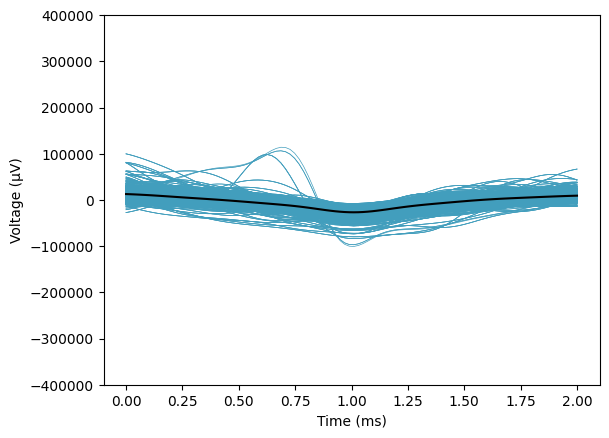

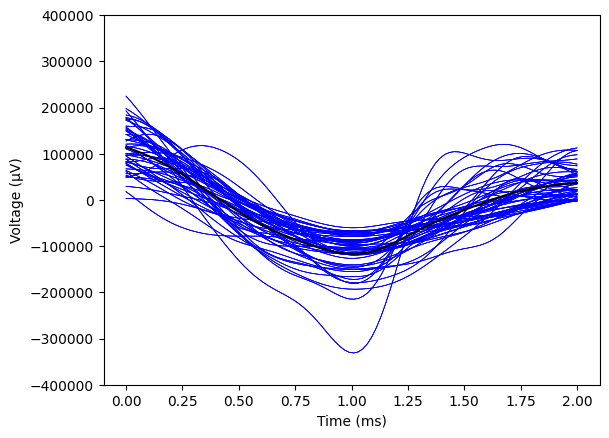

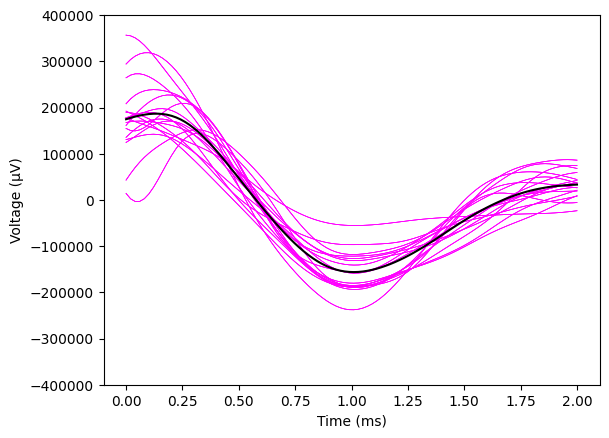

In [ ]:
## line 126

for i in range(desired_k):
    plt.figure()
    # Select data for the current cluster
    cluster_data = data[IDX == i, :]
    # Time vector for plotting
    time = np.linspace(0, (2 * per) * 1e3 / fsSpikes, cluster_data.shape[1])
    # Plot each waveform in the cluster
    for waveform in cluster_data:
        plt.plot(time, waveform, color=color_cluster[i], linewidth=0.5)

    # Calculate the mean waveform for the current cluster
    meanofdata = np.mean(cluster_data, axis=0)
    # Plot the mean waveform
    plt.plot(time, meanofdata, 'k', linewidth=1.5)  # 'k' is for black color

    # plt.title(f'Sorted neuron signals cluster={i+1}')  # i+1 to convert from 0-based to 1-based indexing
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (µV)')
    plt.ylim([-400000, 400000])

plt.show()

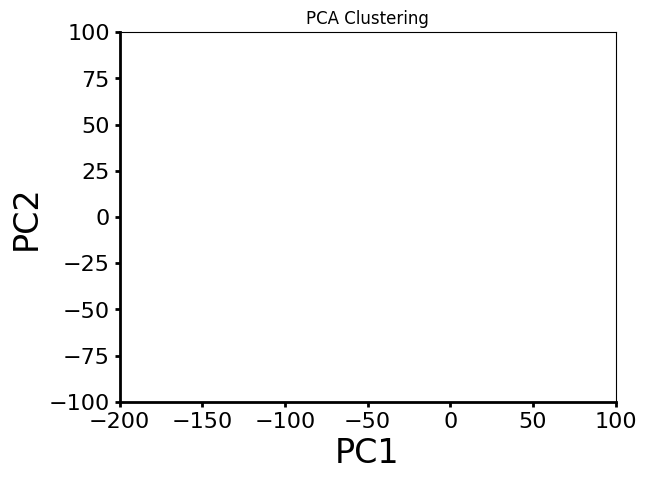

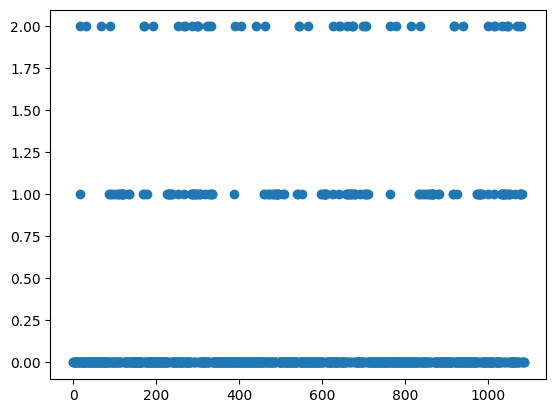

In [ ]:
# line 141

pca = PCA(n_components=3)  # Adjust the number of components as necessary
# pca = PCA()
pca.fit(data)
coeff = pca.components_
score = pca.transform(data)
ev = pca.explained_variance_

## line 147
mu = np.mean(data, axis=0)
marker_neuron = ['o', '*', 's', 'x', 'd', 'p', '+', '.', 'v', '>']

# Plotting PCA results
fig, ax = plt.subplots()

marker_size = 15
neuron = {}
for i in range(desired_k):
    cluster_data = data[IDX == i]
    neuron[i] = (cluster_data - mu) @ coeff.T  # Transform to PCA space

    ax.scatter(-neuron[i][:, 0], -neuron[i][:, 1], marker=marker_neuron[i], color=color_cluster[i], s=marker_size, facecolors='none',linewidths=0.5)

ax.set_xlabel('PC1', fontsize=24)
ax.set_ylabel('PC2', fontsize=24)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=16, width=2)

plt.xlim(-200, 100)
plt.ylim(-100, 100)
plt.title('PCA Clustering')
plt.show()

# Add plot for cluster indices
plt.scatter(range(len(IDX)), IDX)

Please enter the first wanted cluster: 1
Please enter the second wanted cluster: 2


ValueError: x and y must have same first dimension, but have shapes (2999999,) and (2536288,)

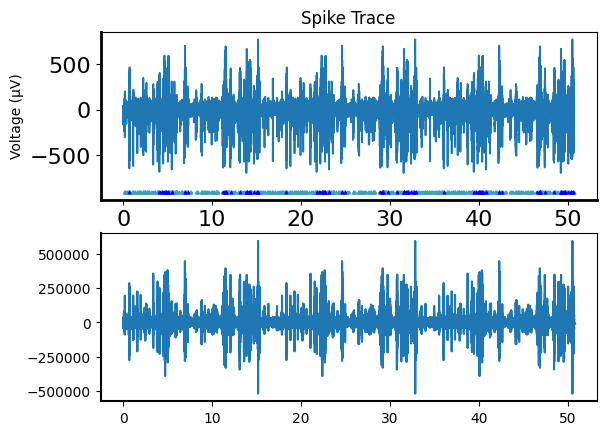

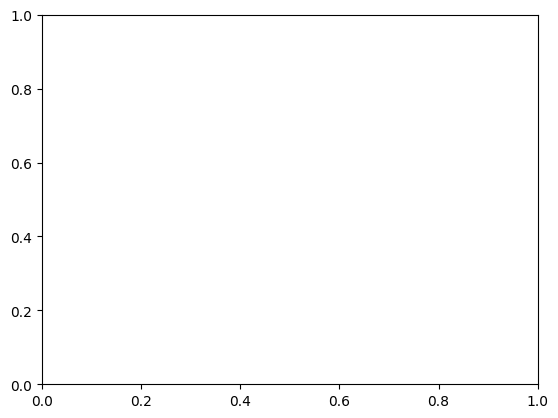

In [ ]:
# line 168

firstcluster = int(input('Please enter the first wanted cluster: '))
secondcluster = int(input('Please enter the second wanted cluster: '))

firstcluster = firstcluster - 1
secondcluster = secondcluster - 1

spike_index = np.array(detected_spikes)
IDX = np.array(IDX)

plt.figure()
hb1 = plt.subplot(2, 1, 1)
plt.plot(np.arange(0, len(rawsignal))/fsSpikes, rawsignal, linewidth=1.3)
plt.title('Spike Trace')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().tick_params(axis='both', which='major', labelsize=16)

timecluster_first = [index + 30 for index, cluster in zip(spike_index, IDX) if cluster == firstcluster]
timecluster_second = [index + 30 for index, cluster in zip(spike_index, IDX) if cluster == secondcluster]

timecluster_first = np.array(timecluster_first)
timecluster_second = np.array(timecluster_second)

plt.scatter(timecluster_first/fsSpikes, -900*np.ones(len(timecluster_first)), s=5, marker='^',
            facecolors=color_cluster[firstcluster], edgecolors=color_cluster[firstcluster], linewidth=0.5)
plt.scatter(timecluster_second/fsSpikes, -900*np.ones(len(timecluster_second)), s=5, marker='^',
            facecolors=color_cluster[secondcluster], edgecolors=color_cluster[secondcluster], linewidth=0.5)

hb2 = plt.subplot(2, 1, 2, sharex=hb1)
plt.plot(np.arange(0, len(spikes))/fsSpikes, spikes, linewidth=1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

timecluster_first = [index for index, cluster in zip(spike_index, IDX) if cluster == firstcluster]
timecluster_second = [index for index, cluster in zip(spike_index, IDX) if cluster == secondcluster]

timecluster_first = np.array(timecluster_first)
timecluster_second = np.array(timecluster_second)

plt.scatter(timecluster_first/fsSpikes, -60*np.ones(len(timecluster_first)), s=5, marker='^',
            facecolors=color_cluster[firstcluster], edgecolors=color_cluster[firstcluster], linewidth=0.5)
plt.scatter(timecluster_second/fsSpikes, -60*np.ones(len(timecluster_second)), s=5, marker='^',
            facecolors=color_cluster[secondcluster], edgecolors=color_cluster[secondcluster], linewidth=0.5)

plt.figure()
time = np.arange(1/fsSpikes, 60, 1/fsSpikes)
trace = spikes[0:60*fsSpikes-1]
plt.plot(time, trace, linewidth=1.5)
plt.ylabel('Voltage (μV)')

plt.scatter(timecluster_first/fsSpikes, -60 * np.ones(len(timecluster_first)), s=5, marker='^',
            facecolors=color_cluster[0], edgecolors=color_cluster[0])
plt.scatter(timecluster_second/fsSpikes, -60 * np.ones(len(timecluster_second)), s=5, marker='^',
            facecolors=color_cluster[3], edgecolors=color_cluster[3])

plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')

# Plot PCA results for selected clusters
plt.figure()
plt.scatter(-neuron[firstcluster][:, 0], -neuron[firstcluster][:, 2],
            color=color_cluster[firstcluster], marker=marker_neuron[firstcluster], s=25)
plt.scatter(-neuron[secondcluster][:, 0], -neuron[secondcluster][:, 2],
            color=color_cluster[secondcluster], marker=marker_neuron[secondcluster], s=25)
plt.xlabel('PC1', fontsize=24)
plt.ylabel('PC2', fontsize=24)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.show()

# Subplots
hc = [None, None, None]

plt.figure()
# First subplot
hc[0] = plt.subplot(3, 1, 1)
plt.plot(np.arange(0, len(rawsignal))/fsSpikes, rawsignal, linewidth=1.5)
timecluster_first = spike_index[IDX == firstcluster] + 30
timecluster_second = spike_index[IDX == secondcluster] + 30
plt.scatter(timecluster_first/fsSpikes, -800*np.ones(len(timecluster_first)),
            s=25, marker='^', facecolors=color_cluster[firstcluster],
            edgecolors=color_cluster[firstcluster])
plt.scatter(timecluster_second/fsSpikes, -800*np.ones(len(timecluster_second)),
            s=25, marker='^', facecolors=color_cluster[secondcluster],
            edgecolors=color_cluster[secondcluster])
plt.xlim(39.8, 40.2)
plt.ylim(-800, 200)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')

In [ ]:
# Second subplot
hc[1] = plt.subplot(3, 1, 2, sharex=hc[0])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')
plt.title('LFP Signal')

plt.plot(np.arange(0, len(LFP))/fsSpikes, LFP, linewidth=1)
plt.ylim(-600, 400)
plt.xlim(1,50)

# Third subplot
hc[2] = plt.subplot(3, 1, 3, sharex=hc[0])
plt.plot(np.arange(0, len(spikes))/fsSpikes, spikes, linewidth=1)
plt.scatter(timecluster_first/fsSpikes, -100*np.ones(len(timecluster_first)),
            s=25, marker='^', facecolors=color_cluster[firstcluster],
            edgecolors=color_cluster[firstcluster])
plt.scatter(timecluster_second/fsSpikes, -100*np.ones(len(timecluster_second)),
            s=25, marker='^', facecolors=color_cluster[secondcluster],
            edgecolors=color_cluster[secondcluster])

plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')
plt.title('Filtered Spikes and Cluster Points')
plt.subplots_adjust(hspace=1)
plt.show()

# Link axes
plt.setp([a.get_xticklabels() for a in hc[:-1]], visible=False)
plt.setp([a.get_yticklabels() for a in hc[:-1]], visible=False)

# Mahalanobis distance and L-ratio calculation
clusterone = neuron[firstcluster][:, :3]
clustertwo = neuron[secondcluster][:, :3]
cov_matrix = np.cov(clusterone.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

d2 = np.array([mahalanobis(point, clusterone.mean(axis=0), inv_cov_matrix) for point in clustertwo])
MD = np.sort(d2)
ID = MD[min(len(clusterone), len(clustertwo)) - 1]
p = chi2.cdf(MD, df=3)
Lratio = np.sum(1 - p) / len(clusterone)

print("L-ratio:", Lratio)